In [ ]:
import matplotlib.pylab as plt
plt.style.use("bmh")

In [ ]:
import numpy as np
import pandas as pd

# Anomalies

In this homework we will look at some simple examples of detecting anomalies in time series. But first, let's try to define, what anomaly is.

In general, **anomaly** is an observable behaviour of the system, which contradicts the underlying dynamics, which we believe is driving the system. Of course, any observable, normal or anomalous, is generated by underlying system dynamics. The real reason we consider some behaviours as normal and some as anomalous is that we use not a real dynamics to describe the system, but either some model, or we want system to demostrate certain desired behaviour.

For example:

- unusually high power consumption in electrical grid may be caused by unusual weather conditions for a certain season, and is thus an absolutely explainable, but grid operator still considers this situation as an anomaly, because unusually high consumption is not a desirable behaviour,
- presense of unusual patterns in sensor reading of industrial equipment may be an indication of some failure coming. In this case, anomaly is not manifested as some extremely high or low way, but rather as an unusual pattern.

In this homework we will consider two datasets:

- [hourly energy consumption data from PJM transmission operator](https://www.kaggle.com/robikscube/hourly-energy-consumption),
- ECG data from [MIT-BIH Arrhythmia Database](https://www.kaggle.com/mondejar/mitbih-database).

# Data

For the first exercise, we will take specific area, served by Commonwealth Edison energy producer. The area is Chicago and part of Illinois. We will look at the data to understand, when consumption is anomalous and will try to explain this anomalies to some extent.

In [ ]:
data = pd.read_csv('COMED_hourly.csv',
                   parse_dates=["Datetime"],
                   index_col="Datetime")

In [ ]:
data.head()

,COMED_MW
Datetime,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


Let's clean-up the field a bit first:

In [ ]:
data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"
data.head()

,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


## Quick exploration

Data definitely demostrates strong seasonality with consumption being higher at summer (air conditioning, apperantly) and during winter (electrical heating, lights etc.):

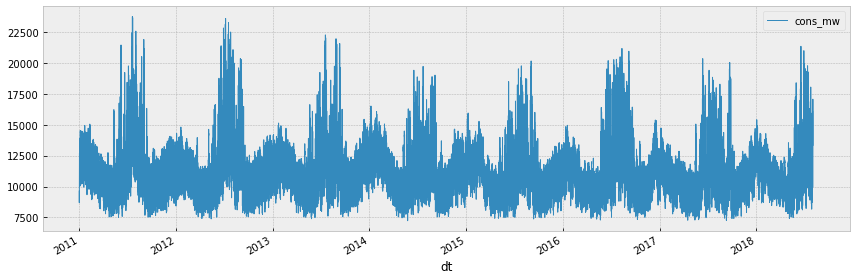

In [ ]:
plt.figure(figsize=(12,4))
data.plot(linewidth=1, ax=plt.gca())
plt.tight_layout()

If we try to calculate rolling average of the data, we will fail, cause original data is not ordered:

In [ ]:
data=data.sort_index()
data.rolling("7D").mean()

,cons_mw
dt,
2011-01-01 01:00:00,9631.000000
2011-01-01 02:00:00,9452.000000
2011-01-01 03:00:00,9305.000000
2011-01-01 04:00:00,9164.000000
2011-01-01 05:00:00,9070.000000
...,...
2018-08-02 20:00:00,12035.815476
2018-08-02 21:00:00,12045.607143
2018-08-02 22:00:00,12054.297619


# Naive anomalies detection

The first and the most simple way to catch unusually high or low values is to just look at rolling average and rolling standard deviation. The assumation is that for a reasonably short period we can use usual statistical approaches, and to say
> if it's outside 3$\sigma$, it's an anomaly

is still somewhat reliable. Let's look at the data at a weekly scale:

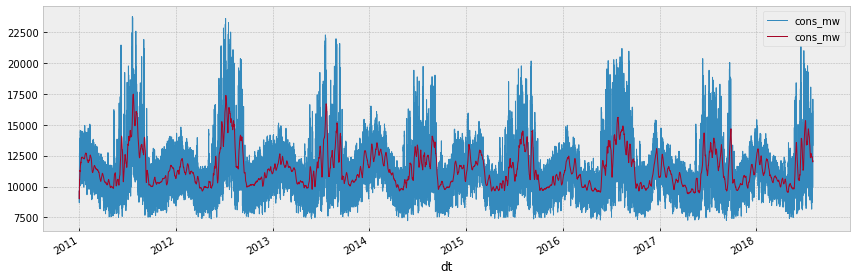

In [ ]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

data.rolling("7D").mean().plot(linewidth=1, ax=plt.gca())

plt.legend(loc=0)
plt.tight_layout()

If we look at the same data on a monthly scale and add "normal" range ($3\sigma$ from rolling average in any direction), we'll start to see hours, which go to high:

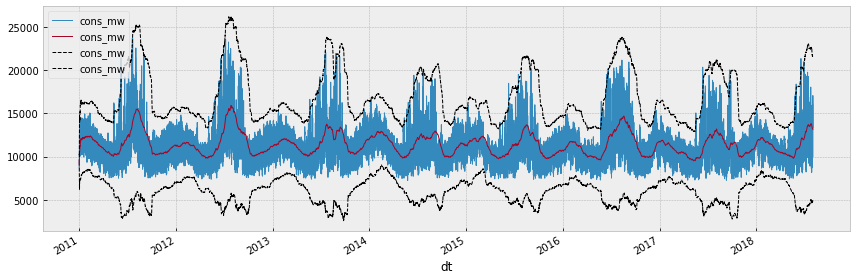

In [ ]:
plt.figure(figsize=(12,4))

data.plot(linewidth=1, ax=plt.gca())

(data
 .rolling("30D")
 .mean()
 .plot(linewidth=1, ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()+3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

((data.rolling("30D").mean()-3*data.rolling("30D").std())
 .plot(linewidth=1, linestyle="--", color="k", ax=plt.gca(), label="rolling average"))

plt.legend(loc=0)
plt.tight_layout()

Let's create a funtion, which searches for such points and creates new dataframe with anomaly indication:

In [ ]:
def detect_anomalies(series, window, factor):
    """Mark all the anomalies, i.e. points, which are outside of `factor*std` range."""

    series_mean = series.rolling(window).mean()
    series_std = series.rolling(window).std()

    result = pd.concat([series,
                        series_mean.rename("_".join([series.name, "rmean"]))],
                       axis=1)
    result = result.join(series_std.rename("_".join([series.name, "rstd"])))
    anomaly = ((series-series_mean)>factor*series_std).astype(int)
    result = result.join(anomaly.rename("anomaly"))
    return result

In [ ]:
data_an = detect_anomalies(data["cons_mw"], "30D", 3.)

In [ ]:
data_an.head()

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.0,NaN,0
2011-01-01 02:00:00,9273.0,9452.0,253.144228,0
2011-01-01 03:00:00,9011.0,9305.0,311.236245,0
2011-01-01 04:00:00,8741.0,9164.0,379.608570,0
2011-01-01 05:00:00,8694.0,9070.0,390.201230,0


In [ ]:
def plot_anomalies(df, d_col, m_col, s_col, a_col, factor):
    """Plot data and annotations."""

    plt.figure(figsize=(12,4))

    # Plot original data
    df[d_col].plot(linewidth=1, ax=plt.gca())

    # Plot rolling average
    df[m_col].plot(linewidth=1, ax=plt.gca())

    # Plot "normal" range
    (df[m_col]+factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())
    (df[m_col]-factor*df[s_col]).plot(linewidth=1, c="k", linestyle="--", ax=plt.gca())

    # Plo anomalies
    df.loc[df[a_col]==1, d_col].plot(linewidth=0,
                                     marker="x",
                                     markersize=2,
                                     c="yellow", linestyle="--",  ax=plt.gca())


    plt.tight_layout()

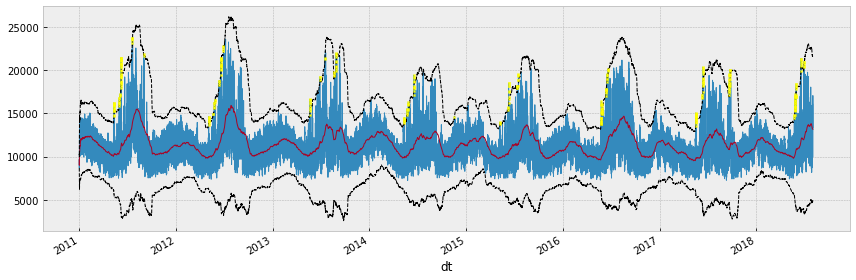

In [ ]:
plot_anomalies(data_an, "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

Although some of the caught anomalies look ok, we immediately can spot several problems:
    
- we definitely underestimate the upper bound of the range, when rolling average goes up very fast,
- we definitely overestimate the upper bound of the range, when rolling average goes down very fast.

This all happens because rolling average is "delayed" relative to underlying time series. Another, probably more severe, problem is non-stationarity, and especially seasonality. Depending on the structure, by doing such a naive anomaly detection we may miss a lot of real anomalies. Can we do better?

# Extracting trends and seasonality

To make our anomaly search more robust, we can remove trend (if any) and seasonality from the time series:

$$series = trend + seasonality + residuals$$.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
result = seasonal_decompose(data["cons_mw"], period=365*24)
result.resid

dt
2011-01-01 01:00:00   NaN
2011-01-01 02:00:00   NaN
2011-01-01 03:00:00   NaN
2011-01-01 04:00:00   NaN
2011-01-01 05:00:00   NaN
                       ..
2018-08-02 20:00:00   NaN
2018-08-02 21:00:00   NaN
2018-08-02 22:00:00   NaN
2018-08-02 23:00:00   NaN
2018-08-03 00:00:00   NaN
Name: resid, Length: 66497, dtype: float64

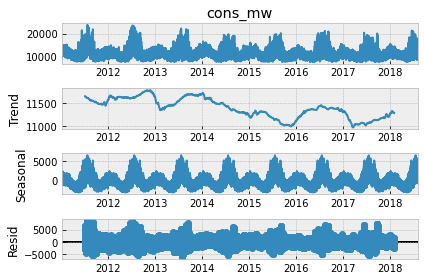

In [ ]:
result.plot()
plt.show()

Looks interesting: we have very pronounced seasonality and a lot of information, not covered by season at all (residuals are of the same range, as seasonal component). This may drive us to conclusion, that we can use residuals as the new series for anomaly detection. Let's try.

In [ ]:
residual_anomalies = detect_anomalies(result.resid.rename("cons_mw_res"), "30D", 3.)

In [ ]:
residual_anomalies

,cons_mw_res,cons_mw_res_rmean,cons_mw_res_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,NaN,NaN,NaN,0
2011-01-01 02:00:00,NaN,NaN,NaN,0
2011-01-01 03:00:00,NaN,NaN,NaN,0
2011-01-01 04:00:00,NaN,NaN,NaN,0
2011-01-01 05:00:00,NaN,NaN,NaN,0
...,...,...,...,...
2018-08-02 20:00:00,NaN,NaN,NaN,0
2018-08-02 21:00:00,NaN,NaN,NaN,0
2018-08-02 22:00:00,NaN,NaN,NaN,0


In [ ]:
data_an.iloc[:, :-1]

,cons_mw,cons_mw_rmean,cons_mw_rstd
dt,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN
2011-01-01 02:00:00,9273.0,9452.000000,253.144228
2011-01-01 03:00:00,9011.0,9305.000000,311.236245
2011-01-01 04:00:00,8741.0,9164.000000,379.608570
2011-01-01 05:00:00,8694.0,9070.000000,390.201230
...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713


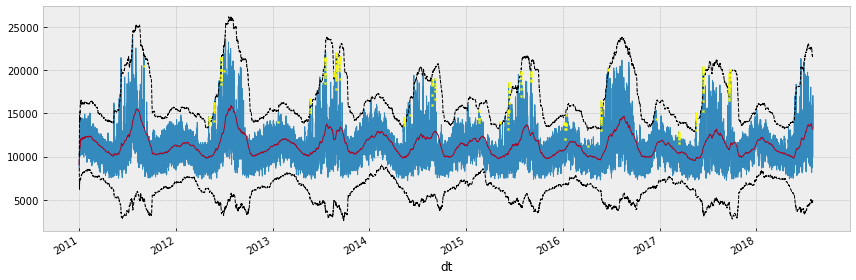

In [ ]:
plot_anomalies(data_an.iloc[:, :-1].join(residual_anomalies["anomaly"]),
               "cons_mw", "cons_mw_rmean", "cons_mw_rstd", "anomaly", 3)

What is interesting, is that locations anomalies are different.

# Next steps

Can we somehow explain the anomalies? Or validate them? Yes, we can. Using the [historical weather dataset](https://www.kaggle.com/selfishgene/historical-hourly-weather-data#city_attributes.csv), we can look, whether temperature explains anomalies to some extent and then improve our anomaly detection algrithm.

In [ ]:
temp_data = pd.read_csv("temperature.csv", parse_dates=["datetime"],
                        usecols=["datetime", "Chicago"], index_col="datetime")
temp_data.head()

,Chicago
datetime,
2012-10-01 12:00:00,NaN
2012-10-01 13:00:00,284.010000
2012-10-01 14:00:00,284.054691
2012-10-01 15:00:00,284.177412
2012-10-01 16:00:00,284.300133


In [ ]:
data_an

,cons_mw,cons_mw_rmean,cons_mw_rstd,anomaly
dt,,,,
2011-01-01 01:00:00,9631.0,9631.000000,NaN,0
2011-01-01 02:00:00,9273.0,9452.000000,253.144228,0
2011-01-01 03:00:00,9011.0,9305.000000,311.236245,0
2011-01-01 04:00:00,8741.0,9164.000000,379.608570,0
2011-01-01 05:00:00,8694.0,9070.000000,390.201230,0
...,...,...,...,...
2018-08-02 20:00:00,16437.0,13179.456944,2756.544596,0
2018-08-02 21:00:00,15590.0,13176.827778,2753.335103,0
2018-08-02 22:00:00,15086.0,13174.450000,2750.941713,0


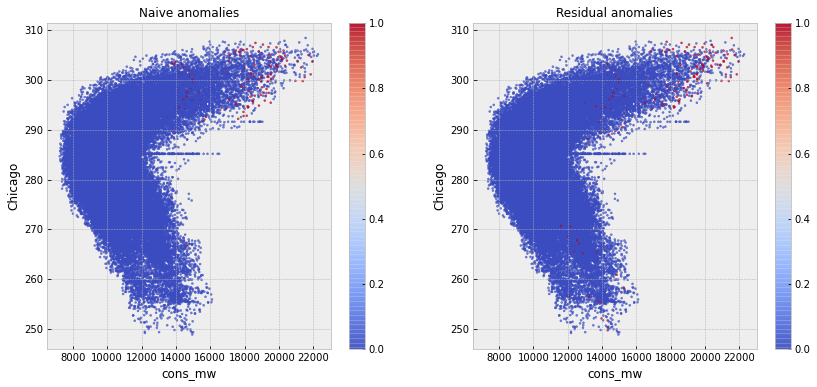

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

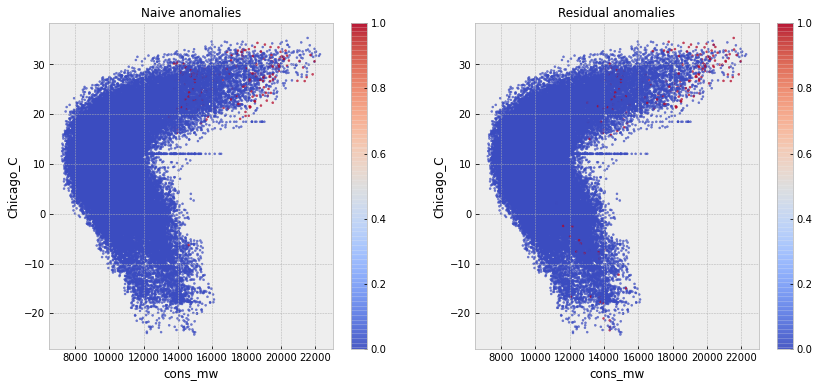

In [ ]:
from scipy.constants import convert_temperature

temp_data['Chicago_C'] = convert_temperature(temp_data.Chicago,'Kelvin', 'Celsius')

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
naive_anomalies = temp_data.join(data_an)
naive_anomalies.plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Naive anomalies", fontsize=12)

plt.subplot(1,2,2)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
naive_anomalies.plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, c=naive_anomalies.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=plt.gca())
plt.title("Residual anomalies", fontsize=12);

<font color='blue'> We can try to visualize the same for summer/winter periods,  separately.</font>

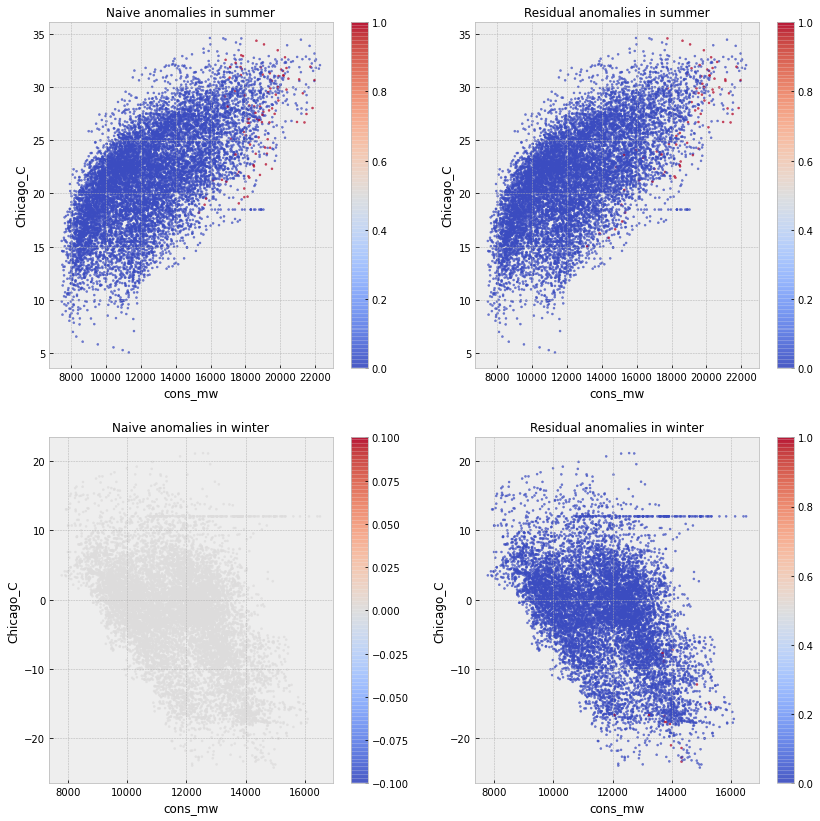

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14,14))
axs = axs.flatten()
naive_anomalies = temp_data.join(data_an)
naive_anomalies = naive_anomalies.join(residual_anomalies["anomaly"], rsuffix="_res")
summer = naive_anomalies.index.month.isin([6, 7, 8])
winter = naive_anomalies.index.month.isin([12, 1, 2])

naive_anomalies[summer].plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=naive_anomalies[summer].anomaly,
                     cmap=plt.cm.coolwarm, ax=axs[0])
axs[0].set_title("Naive anomalies in summer", fontsize=12)

naive_anomalies[summer].plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=naive_anomalies[summer].anomaly_res,
                     cmap=plt.cm.coolwarm, ax=axs[1])
axs[1].set_title("Residual anomalies in summer", fontsize=12);

naive_anomalies[winter].plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=naive_anomalies[winter].anomaly,
                             cmap=plt.cm.coolwarm, 
                             ax=axs[2])
axs[2].set_title("Naive anomalies in winter", fontsize=12)

naive_anomalies[winter].plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=naive_anomalies[winter].anomaly_res,
                     cmap=plt.cm.coolwarm, ax=axs[3])
axs[3].set_title("Residual anomalies in winter", fontsize=12);

<font color='blue'> There are almost no anomalies in winter.</font>

Btw, can you extract season (summer/winter) from this images? Try to play with some clustering here.

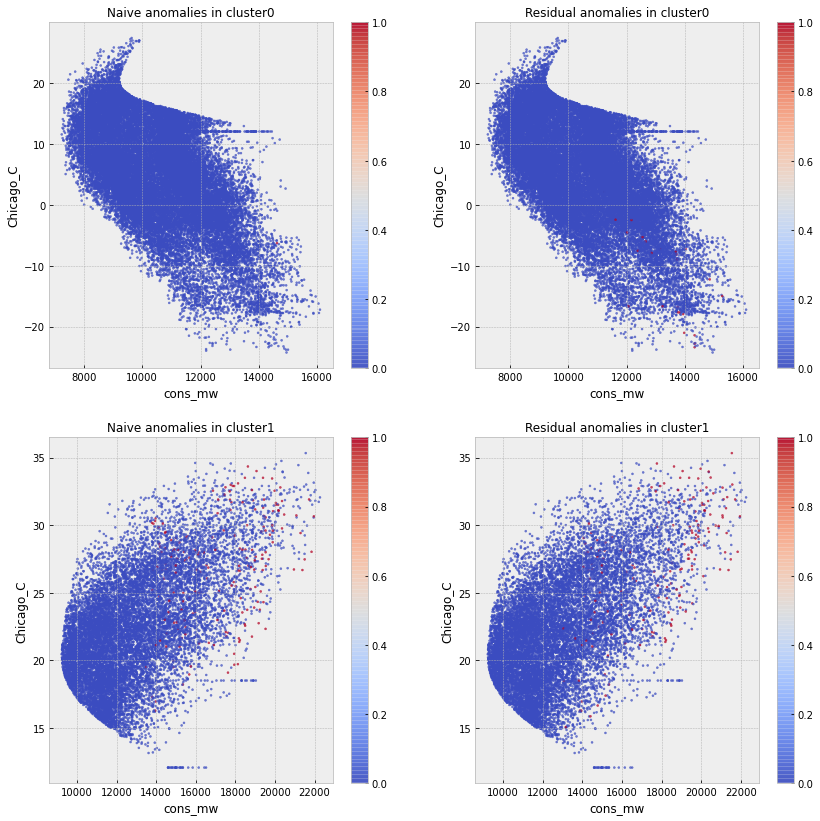

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('scaler', StandardScaler()), ('gm', GaussianMixture(n_components=2, random_state=0))])
pred = pipeline.fit_predict(naive_anomalies[['Chicago_C', 'cons_mw']].dropna())

fig, axs = plt.subplots(2, 2, figsize=(14,14))
axs = axs.flatten()
cluster0 = naive_anomalies.dropna()[pred==0]
cluster1 = naive_anomalies.dropna()[pred==1]

cluster0.plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=cluster0.anomaly,
                     cmap=plt.cm.coolwarm, ax=axs[0])
axs[0].set_title("Naive anomalies in cluster0", fontsize=12)

cluster0.plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=cluster0.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=axs[1])
axs[1].set_title("Residual anomalies in cluster0", fontsize=12);

cluster1.plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=cluster1.anomaly,
                             cmap=plt.cm.coolwarm, 
                             ax=axs[2])
axs[2].set_title("Naive anomalies in cluster1", fontsize=12)

cluster1.plot(x="cons_mw", y="Chicago_C", kind="scatter", s=4, alpha=0.7, 
                             c=cluster1.anomaly_res,
                     cmap=plt.cm.coolwarm, ax=axs[3])
axs[3].set_title("Residual anomalies in cluster1", fontsize=12);

<font color='blue'> To be honest, the result of the clustering is not pretty good (but at least, some division to warm/cold periods is visible).</font>

## Intermediate conclusions

We can make two conslusions from the plots above:

- temperature alone is a strong influencer of energy consumption,
- thus, some of the anomalies, that we detected looking only at consumption, are perfectly ok, if you add temperature into consideration.

Let's improve our detection approach, and look at both consumption and temperature. For this, we will use algorithm called Local Outlier Factor detection. In a simple terms, it looks at local density, and tryis to estimate, how strongly a point is embedded into the data.

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
en_temp = temp_data.join(data_an)[["Chicago", "cons_mw"]]

In [ ]:
en_temp = en_temp[~en_temp.isnull().any(axis=1)]
en_temp

,Chicago,cons_mw
2012-10-01 13:00:00,284.010000,11426.0
2012-10-01 14:00:00,284.054691,11522.0
2012-10-01 15:00:00,284.177412,11574.0
2012-10-01 16:00:00,284.300133,11489.0
2012-10-01 17:00:00,284.422855,11309.0
...,...,...
2017-11-29 20:00:00,281.340000,12171.0
2017-11-29 21:00:00,281.690000,11998.0
2017-11-29 22:00:00,281.070000,11681.0
2017-11-29 23:00:00,280.060000,11148.0


Let's try default parameters first:

In [ ]:
detector = LocalOutlierFactor()
factors = detector.fit_predict(en_temp)

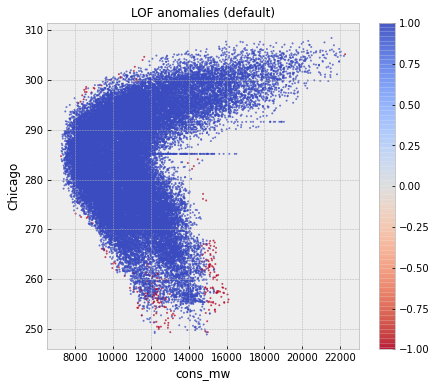

In [ ]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Not that bad, but it looks like our detector is a bit too harsh. Let's make it softer:

In [ ]:
soft_detector = LocalOutlierFactor(contamination=0.025, n_neighbors=10)
factors = soft_detector.fit_predict(en_temp)

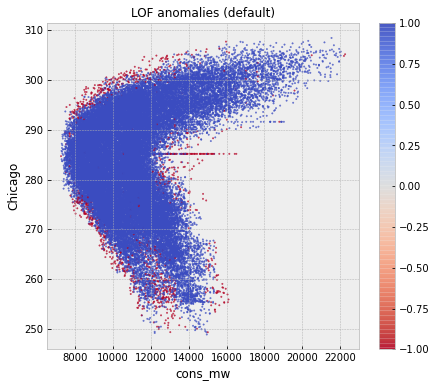

In [ ]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=factors,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

In [ ]:
from sklearn.ensemble import IsolationForest
detector2 = IsolationForest(contamination = 0.025)
factors2 = detector2.fit_predict(en_temp)

In [ ]:
dv = detector2.decision_function(en_temp)

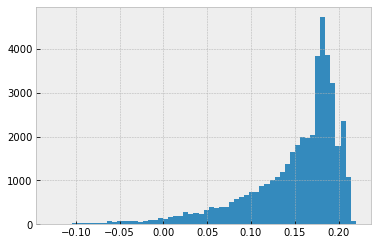

In [ ]:
plt.hist(dv, bins=60);

In [ ]:
color = np.zeros_like(dv)
color[dv > 0] = 1

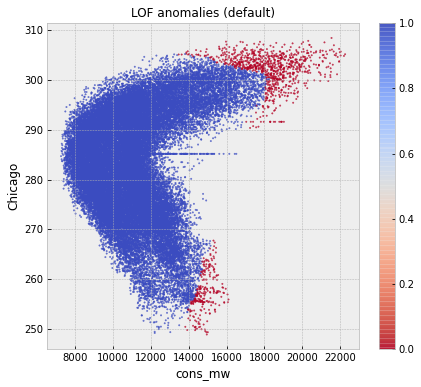

In [ ]:
plt.figure(figsize=(7,6))

en_temp.plot(x="cons_mw", y="Chicago", kind="scatter", s=2, alpha=0.7, c=color,
                     cmap=plt.cm.coolwarm_r, ax=plt.gca())
plt.title("LOF anomalies (default)", fontsize=12);

Contamination parameter defines, how many outliers we have in the data. `0.025` means `once in 40 hours`, which is reasonable, but depends, of course, on which grid operator we consider.

Now that we looked at basics of outlier/anomaly detection, you can play with it further, for example, try IsolationForest algorithm. You may benefit from reading the discussion on how outlier is different from novelty at [`sklearn` User guide](https://scikit-learn.org/stable/modules/outlier_detection.html).

# Structural anomalies

Although you often can spot anomalies just by values, it often happens that anomalies are hidden in data structure. For example, peak frequency of the signal changes, which is sometimes quite hard to spot by eye, or some other **structural** changes take place.

In this case anomalies are detected in a more elaborate way. The most straightforward approach is to somehow quantify signal structure (power spectrum is a good example, as well as mean crossing rate).

We will not go deep into explanations of how this works from medical prospective, and will look at data itself mostly.

In [ ]:
mit = pd.read_csv("234.csv")

In [ ]:
mit.head()

,'sample #','MLII','V1'
0,0,1008,1051
1,1,1008,1051
2,2,1008,1051
3,3,1008,1051
4,4,1008,1051


In [ ]:
mit.columns = ["sample", "MLII", "V1"]

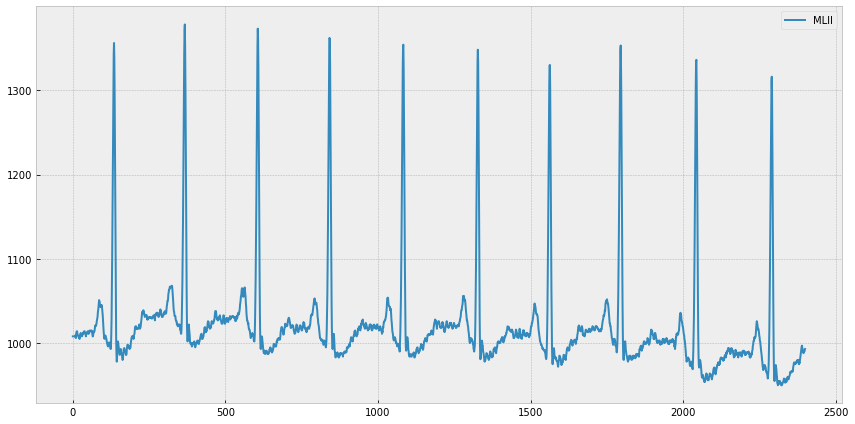

In [ ]:
plt.figure(figsize=(12,6))
mit["MLII"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

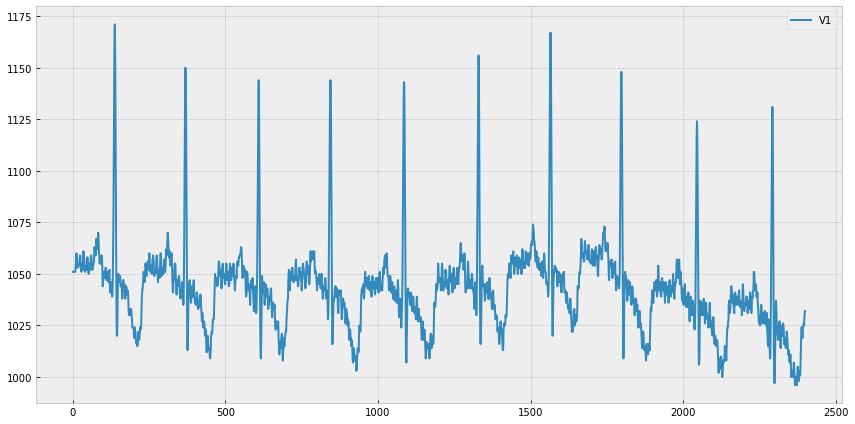

In [ ]:
plt.figure(figsize=(12,6))
mit["V1"].iloc[:2400].plot(legend=True, ax=plt.gca())
plt.tight_layout()

As you can see, data has very strong temporal pattern. Failure in following this pattern is an indication of underlying medical condition and can be detected automatically.

In [ ]:
# annotations = pd.read_csv("234annotations.txt", sep="\s+")

In [ ]:
# annotations.columns = ["timestamp", "sample", "type", "sub", "chan", "num", "aux", "smth"]

In [ ]:
# annotations = annotations[annotations.columns[:-1]]

In [ ]:
# annotations.info()

In [ ]:
# annotations['type'].value_counts()

There are many approaches to detection of structural anomalies. Depending on the signal, we can

- **construct some aggreagates for rolling windows,** and do the same thing we did with energy consumption. For example, we may calculate peak frequency, or power in some specific spectral band. This approach works well for signals, which do not have strict repetitive structure, but generally have some normal parameters. For example, for rotating (motors, generators, and so on) industrial equipment drift in peak frequency may indicate problems,
- **construct some forecasting model,** and look at large deviations between forecasts and real values. This works well for

a) signals with autoregressive structure (energy consumption is a good example), and hence the model is some kind of AR model (AR, VAR, ARIMA, whatever works), 

b) for signals with clear and repetitive structure (ECG and EEG are good examples), and in this case we need to build a nonlinear model for forecasting.

Since we have a signal with very strict temporal pattern, we may try to model it and look at divergence between what model predicts (i.e. the temporal structure model catched) and real values.

We will take last 50 values (this number is a bit out of the blue, but if you look at signal, you'll see, that it should be ok). 
This will basicly allow us to convert our time series into a "point anomaly" problem

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
# train_signal = mit[:30000]
# cv_signal = mit[:30050]
# test_signal = mit[40050:50000]

In [ ]:
# plt.figure(figsize=(12,6))
# train_signal.MLII.plot()
# plt.tight_layout()

We won't go into hyperparameters tuning, we only need to know, that our model cross-validaties.

In [ ]:
WINDOW = 50

In [ ]:
signal = mit[:15000]

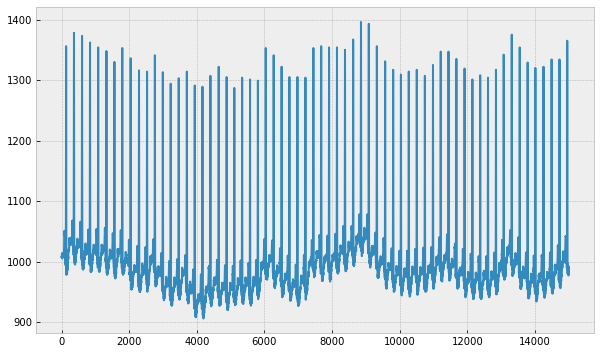

In [ ]:
signal.MLII.plot(figsize=(10,6));

In [ ]:
features = {}

for i in signal.index[50:]:
    fts = (signal.loc[i-WINDOW:i-1, ["MLII", "V1"]]
           .reset_index(drop=True)
           .stack(dropna=False)
           .to_frame()
           .reset_index())
    fts.index = fts.level_1.str.cat(fts.level_0.astype(str), sep="_")
    features[i] = fts.loc[:, 0]
features = pd.DataFrame.from_dict(features, orient="index")

In [ ]:
print(features.shape)
features.head()

(14950, 100)


,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [ ]:
features.head()

,MLII_0,V1_0,MLII_1,V1_1,MLII_2,V1_2,MLII_3,V1_3,MLII_4,V1_4,...,MLII_45,V1_45,MLII_46,V1_46,MLII_47,V1_47,MLII_48,V1_48,MLII_49,V1_49
50,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1011,1052,1012,1056,1013,1058,1013,1058,1014,1058
51,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1012,1056,1013,1058,1013,1058,1014,1058,1014,1052
52,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1013,1058,1014,1058,1014,1052,1011,1052
53,1008,1051,1008,1051,1008,1051,1008,1051,1008,1051,...,1013,1058,1014,1058,1014,1052,1011,1052,1011,1050
54,1008,1051,1008,1051,1008,1051,1008,1051,1009,1051,...,1014,1058,1014,1052,1011,1052,1011,1050,1012,1054


In [ ]:
model = RandomForestRegressor(n_estimators=500, max_depth=4)
model.fit(features[:7500], signal.loc[features[:7500].index, "V1"])

RandomForestRegressor(max_depth=4, n_estimators=500)

In [ ]:
print("CV MSE:", mean_squared_error(model.predict(features[7500:10000]),
                                    signal.loc[features[7500:10000].index, "V1"]))

CV MSE: 31.528336283339442


Ok, looks like it works just fine, let's look at forecasts:

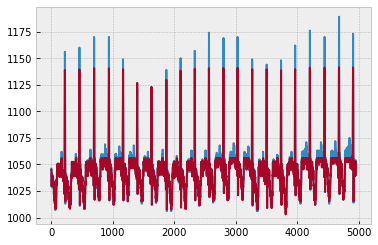

In [ ]:
plt.plot(signal.loc[features[10000:].index, "V1"].values)
plt.plot(model.predict(features[10000:]))

We see, that model is not ideal, but we do not plan to use it directly. Instead, we will look at longer time intervals:

In [ ]:
indicator = pd.DataFrame(np.vstack([signal.loc[features[10000:].index, "V1"].values,
                                    model.predict(features[10000:])]).T,
                        columns = ["y_true", "y_pred"], index=features[10000:].index)

In [ ]:
indicator["y_diff"] = (indicator["y_true"]-indicator["y_pred"]).abs()

<AxesSubplot:>

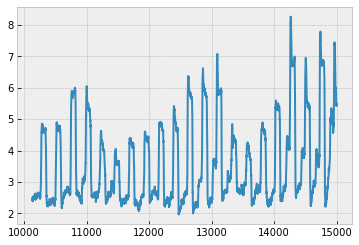

In [ ]:
indicator["y_diff"].rolling(80).mean().plot()

Now, by thresholding the rolling averages difference between forecast and actual values, we can detect anomalous behaviour.

# Assignment

**Task 1 (_max score - 20 points_)** Calculate features for a longer period of time, so that the model can be trained to better match the real signal.

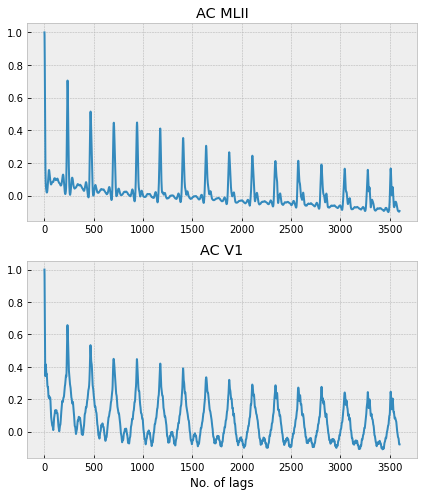

In [ ]:
# To choose the longer time period let's look at the autocorrolation of the signals:
from statsmodels.tsa.stattools import acf

mlii_acf = acf(mit[:15000].MLII.to_numpy(), nlags=3600, fft=False) 
v1_acf = acf(mit[:15000].V1.to_numpy(), nlags=3600, fft=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8))

ax1.plot(mlii_acf)
ax1.set_title('AC MLII')
ax2.plot(v1_acf)
ax2.set_title('AC V1')
ax2.set_xlabel('No. of lags');

<font color='blue'>In time series analysis, especially for building the ARIMA models, a nice way to select the parameters of the model (the values of AR and MA) is to plot the autocorrelation and partial autocorrelation functions. Here, in the task, the same idea also can be used to find the appropriate number of lags.</font>

In [ ]:
# As we can see above, the two signals have a strong autocorrelation (~70%) around the 250 lag,
# and the correlation peaks again every ~250 lags but with decreasing amplitude,
# meaning the signal is less correlated over longer lags.

# let's examain the peak aroud lag ~250
max_peak_mlii = np.argmax(mlii_acf[200:]) + 200
max_peak_v1 = np.argmax(v1_acf[200:]) + 200

print('MLII: peak located in lag %d' % max_peak_mlii)
print('V1: peak located in lag %d' % max_peak_v1)

MLII: peak located in lag 234
V1: peak located in lag 233


In [ ]:
# Both peaks are almost in the same lag, so we can try take 234 as our new window to compute the features.
# To compute the features let's the use our faster function seq2point

def seq2point(df, cols, WINDOW):
    
    k = len(cols)
    signal_values = df[cols].to_numpy().reshape(-1, k)
    n = signal_values[WINDOW:, :].shape[0]
    m = k * WINDOW
    features = np.ndarray((n, m))
    
    for i in range(signal_values[WINDOW:, :].shape[0]):
        features[i] = signal_values[i:i+WINDOW, :].flatten()

    cols = ['_'.join([name, str(num)]) for name, num in zip(list(cols) * m, np.repeat(range(m // k), k))]
    index = df.index[range(WINDOW, n + WINDOW)]
    return pd.DataFrame(features, columns = cols, index = index, dtype = int)

In [ ]:
# Prepare the datasets

# Note: after testing the longer sequence window of 234 suggested above, we didn't find any improvement in the MSE score,
# however, using more samples (rather then more features) and modifying the model parameters improved the MSE score as follows:

win = 50 
train_size = 30_000 + win
test_size = 7_500

signal = mit.loc[:train_size + 2*test_size + win]
features = seq2point(signal, signal.columns[1:], win)

train_signal = features.loc[:train_size - 1]
valid_signal = features.loc[train_size + 1 : train_size + test_size]
test_signal = features.loc[train_size + test_size + 1:]

y_train = signal.loc[train_signal.index, "V1"]
y_valid = signal.loc[valid_signal.index, "V1"]
y_test = signal.loc[test_signal.index, "V1"]

print(*map(np.shape, [train_signal, valid_signal, test_signal]))

(30000, 100) (7500, 100) (7550, 100)


In [ ]:
# Train the model
# We reduce the number of estimators just for a quicker run, 
# and we compensate with the min_samples_leaf and min_samples_split to be more general.
# The improvement in the MSE is simply by adding more depth to the trees.
model = RandomForestRegressor(n_estimators = 100, max_depth = 10, n_jobs = -1, min_samples_leaf = 3, min_samples_split = 5)

model.fit(X = train_signal, y = y_train)

# previous CV MSE with window size = 50 was 31.582925803166173
print("Validation MSE:", mean_squared_error(model.predict(valid_signal), y_valid))

Validation MSE: 8.024798268969807


**Task 2 (_max score - 20 points_)** Calculate differences. Are they are ok to serve as anomaly detection?

<font color='blue'>The residuals can be used for anomaly detection since the anomaly can be found in the difference itself. However in the figure below, we can see large peaks in the residual which corresponds to the original signal peaks.</font>

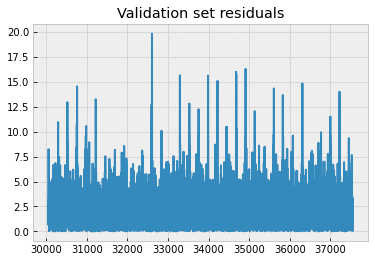

In [ ]:
# Calculate the differences and calibrate hyperparameters on validation set, and only then apply on the test set.

yhat_valid = model.predict(valid_signal)
resid_valid = np.abs(y_valid - yhat_valid)
resid_valid.plot(title = 'Validation set residuals');

<font color='blue'> If we threshold the anomalies in the plot above, almost every peak of the original dataset will be considered as an anomaly (which is incorrect, because for such kind of data, the peaks are the normal behaviour).</font>

**Task 3 (_max score - 20 points_)** Why we use rolling average instead of difference between forecast and actual values?

<font color='blue'> As we can see in the figure above, sharp peaks are dominating in the residuals signal,
and can be explained as the difference between the original peaks in the signal and the predicted ones.
In order to emphasize also the contextual anomalies and to reduce the dominance of the peaks,
we can use rolling average to smooth the signal and apply on it some threshold value to catch the anomalies indices. </font>

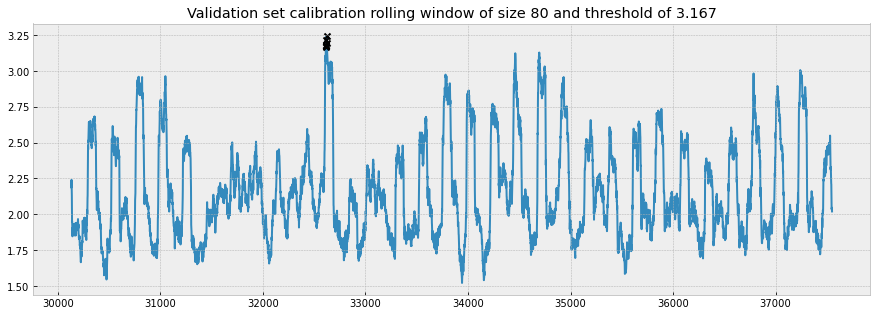

In [ ]:
# smooth in order to choose threshold
w = 80
resid_valid_smooth = resid_valid.rolling(w).mean()

th = resid_valid_smooth.quantile(0.999) # Q999 as threshold value
indicator_val = resid_valid_smooth > th
annomaly_val = indicator_val[indicator_val].index 

resid_valid_smooth.plot(figsize=(15, 5), zorder = 0)
plt.scatter(annomaly_val, resid_valid_smooth[annomaly_val], c='k', marker = 'x')
plt.title(f'Validation set calibration rolling window of size {w} and threshold of {round(th, 3)}');

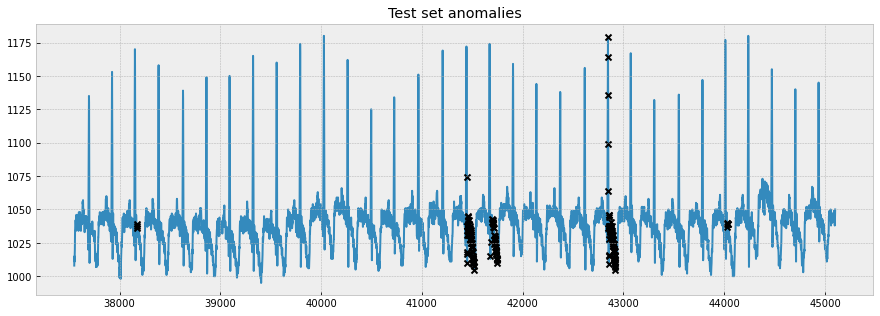

In [ ]:
# Now apply model and hyperparameters on the test set:

yhat = model.predict(test_signal)

resid = np.abs(y_test - yhat)

anomalies = resid.rolling(w).mean() > th
anomalies = anomalies[anomalies].index

y_test.plot(figsize=(15, 5), zorder = 0)
plt.scatter(anomalies, y_test[anomalies], c='k', marker = 'x')
plt.title('Test set anomalies');

Note: as we can see, we were able to separate some heartbeats from the rest of fairly similar beats (for the naked eye). In addition, we were able to mark not only the beat itself, but also the some more steps after the beat as anomalous by using moving average and thresholding. 


**Task 4 (_max score - 40 points_)** Implement the same approach (what we did from the title Structural anomalies) to the energy consumption problem.

In [ ]:
data = pd.read_csv('COMED_hourly.csv',
                   parse_dates=["Datetime"],
                   index_col="Datetime")

data.rename({"COMED_MW":"cons_mw"}, axis=1, inplace=True)
data.index.name = "dt"
data.head()

,cons_mw
dt,
2011-12-31 01:00:00,9970.0
2011-12-31 02:00:00,9428.0
2011-12-31 03:00:00,9059.0
2011-12-31 04:00:00,8817.0
2011-12-31 05:00:00,8743.0


In [ ]:
data.sort_index(inplace=True)

In [ ]:
data.index.shape, data.index.drop_duplicates().shape

((66497,), (66493,))

In [ ]:
data = data.loc[~data.index.duplicated()]

In [ ]:
WINDOW = 24
energy_features = seq2point(data, [data.columns[0]], WINDOW)

ef_train = energy_features.loc['2011-01-01':'2014-12-31']
ef_valid = energy_features.loc['2015-01-01':'2016-05-31']
ef_test = energy_features.loc['2016-06-01':]

In [ ]:
energy_train_y = data.loc[ef_train.index]
energy_valid_y = data.loc[ef_valid.index]
energy_test_y = data.loc[ef_test.index]

print('Xs:', *map(np.shape, [ef_train, ef_valid, ef_test]))
print('ys:', *map(np.shape, [energy_train_y, energy_valid_y, energy_test_y]))

Xs: (35032, 24) (12406, 24) (19031, 24)
ys: (35032, 1) (12406, 1) (19031, 1)


In [ ]:
model2 = RandomForestRegressor(**model.get_params())
model2.fit(ef_train, energy_train_y.to_numpy().flatten())

RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                      n_jobs=-1)

In [ ]:
print("Validation MSE:", mean_squared_error(model2.predict(ef_valid), energy_valid_y.to_numpy().flatten()))

Validation MSE: 29551.507269354486


In [ ]:
# calculate the differences

yhat_energy = model2.predict(ef_test)
resid_energy = np.abs(energy_test_y - np.atleast_2d(yhat_energy).T)

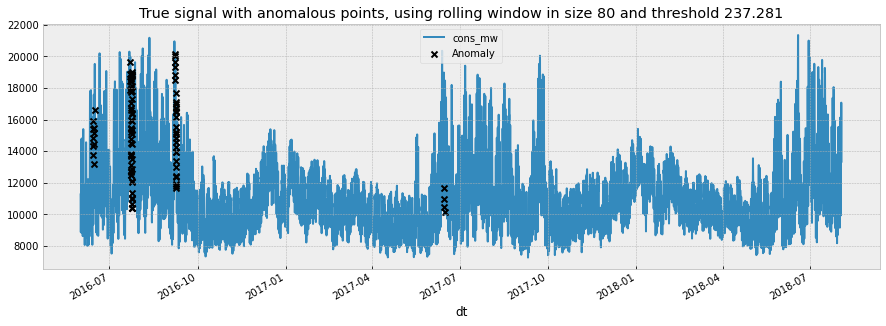

In [ ]:
resid_energy_smooth = resid_energy.rolling(w).mean()
th_energy = resid_energy_smooth.quantile(0.995).values[0]

indicator_energy = resid_energy_smooth > th_energy
indicator_energy = indicator_energy[indicator_energy.values].index

energy_test_y.plot(figsize=(15, 5), zorder = 0, label='Signal')
plt.scatter(indicator_energy, energy_test_y.loc[indicator_energy], c='k', marker='x', label='Anomaly')
plt.title(f'True signal with anomalous points, using rolling window in size {w} and threshold {round(th_energy, 3)}');
plt.legend()

As we can see, we were able to separate anomalies points, differently from methods presented in the beginning of this notebook.

<font color='blue'> The value of a quantile is ok to use as a threshold for anomaly detection, another option is to use _mean + factor * std_. </font>
